In [1]:
import itertools
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm_notebook
from dataclasses import asdict, dataclass, field
import vsketch
import shapely.geometry as sg
from shapely.geometry import box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString
import shapely.affinity as sa
import shapely.ops as so
import matplotlib.pyplot as plt
import pandas as pd

import vpype_cli
from typing import List, Generic
from genpen import genpen as gp, utils as utils
from scipy import stats as ss
import geopandas
from shapely.errors import TopologicalError
import functools
%load_ext autoreload
%autoreload 2
import vpype
from skimage import io
from pathlib import Path

import bezier

from sklearn.preprocessing import minmax_scale
from skimage import feature
from genpen.utils import Paper

from scipy import spatial, stats
from scipy.ndimage import gaussian_filter
from scipy.integrate import odeint
from functools import partial

from genpen.grower import *
import fn
from genpen.axicam import AxiCam

In [4]:
# make page
paper_size = '11x14 inches'
border:float=40
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)
db = gp.Poly(drawbox)

# background

In [81]:
# make page
paper_size = '11x14 inches'
border:float=40
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)
db = gp.Poly(drawbox)

ygen = stats.triang(loc=db.bottom, c=0, scale=db.height).rvs
pts = gp.get_random_points_in_polygon(db.p, n_points=500, ygen=ygen)

pts += [Point(x, db.top) for x in np.linspace(db.left, db.right, 5)]

polys = so.triangulate(MultiPoint(pts))

bps = []
for poly in polys:
    bd = np.interp(poly.centroid.y, (db.bottom, db.top- db.height*0.1), (-3, 0))
    bps.append(poly.buffer(bd, cap_style=2))

MultiPolygon(bps)

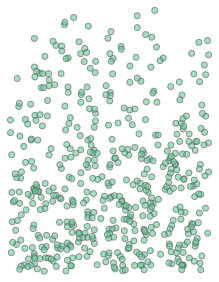

# foreground

In [60]:
start_point = Point(db.p.centroid.x, db.bottom + 20)
target_point = Point(db.p.centroid.x, db.top - 20)

In [71]:
g.selected_pts

,geometry,loss
8,POINT (131.130 226.487),69.642424


In [154]:
params = GrowerParams(
    rad_func='loss_scaled_rad',
    rad_range=(10, 1),
    loss_range=(100, 250),
    n_pts_eval_per_iter=5,
    n_pts_add_per_iter=1,
    pt_to_poly_func='buffer_pt',
    n_corners=7,
    loss_func='distance_from_target',
    halt_condition_func='below_loss_threshold',
    loss_threshold=100,
)
g = Grower(poly=start_point.buffer(1), params=params, target=target_point)

In [155]:
g.grow(150)

 63%|██████▎   | 95/150 [00:04<00:02, 21.50it/s] 


In [156]:
g._p.loss_range = (50, 100)
g._p.loss_threshold = 50

In [157]:
g.grow(100)

 81%|████████  | 81/100 [00:11<00:02,  7.32it/s]


In [159]:
g._p.loss_range = (10, 50)
g._p.loss_threshold = 10

In [160]:
g.grow(100)

 48%|████▊     | 48/100 [00:10<00:11,  4.71it/s]


In [162]:
g._p.loss_range = (10, 100)
g._p.halt_condition_func = 'return_false'
g._p.rad_range=(15, 1)
g._p.n_pts_eval_per_iter=24

In [163]:
g.selected_pts

,geometry,loss
0,POINT (142.382 286.284),9.694807


In [164]:
g.grow(200)

100%|██████████| 200/200 [04:42<00:00,  1.41s/it]


In [135]:
g._p.loss_range = (10, 100)
g._p.halt_condition_func = 'return_false'
g._p.rad_range=(15, 1)
g._p.n_pts_eval_per_iter=24,

In [136]:
g.grow(200)

100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


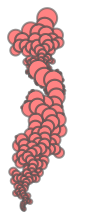

In [158]:
g.mpoly

In [11]:
polys = gp.make_like(gp.merge_Polygons([p.buffer(-0.1, cap_style=2, join_style=2) for p in g.polys]), drawbox)

In [12]:
fills = []
for poly in polys:
    prms = gp.ScaleTransPrms(
        n_iters=200,
        d_buffer=ss.uniform(loc=-5.5, scale=1.3).rvs(),
        d_translate_factor=0.6,
        angles=ss.uniform(loc=0, scale=180).rvs(),
    )
    p = gp.Poly(poly)
    p.fill_scale_trans(**prms.prms)
    fills.append(p.fill)

In [13]:
lss = gp.merge_LineStrings(fills)

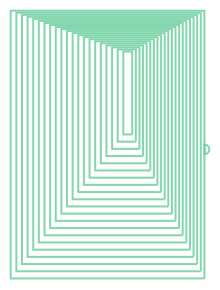

In [14]:
lss

In [ ]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')

counter = 0
for ls in lss:
    counter += 1
    sk.stroke(counter)
    sk.geometry(ls)
    
sk.display(color_mode='layer')

In [ ]:
import fn

In [ ]:
plot_id = fn.new_plot_id()

In [ ]:
savedir='/home/naka/art/plotter_svgs'

In [ ]:
savepath = Path(savedir).joinpath(f'{plot_id}.svg').as_posix()
sk.save(savepath)